### Corrélation entre la durée du film et la complexité émotionnelle (Florian ze beste)

Les films plus longs (plus de 2 heures) présentent-ils des arcs émotionnels plus complexes que les films plus courts ? Le max minute c’est 300min, 4h30
Hypothèse : Les films longs ont plus d'espace narratif pour développer des variations émotionnelles. (Avec les time steps c’est hyper quantifiable askip) 
On peut regarder la différence d’émotions entre time step, on peut voir à quel point y’a des variations, on peut regarder si ces variations changent beaucoup avec des catégories de films qui sont plus longues (2h+) et moins que ca 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import pearsonr

import plotly.express as px
import pandas as pd
from scipy.stats import ttest_ind
import plotly.io as pio



In [3]:
# Define data path constants
DATA_PATH_EMOTIONS = "../../../data/emotions_interpolated_20.pkl"
DATA_PATH_OLD_MOVIE = "../../../data/our_movie_data.csv"
DATA_PATH_MOVIE = "../../../data/final_dataset.csv"



In [4]:


def load_emotions_data(path):
    with open(path, 'rb') as f:
        df = pickle.load(f)
    return df

df = load_emotions_data(DATA_PATH_EMOTIONS)
df.head(2)


,anger,disgust,fear,joy,neutral,sadness,surprise,Wikipedia_movie_ID,timestep
0,0.008854,0.029581,0.002972,0.115284,0.753907,0.025629,0.063773,3333,0
1,0.020809,0.070973,0.033560,0.082080,0.771024,0.012630,0.008924,3333,1


In [5]:
DATA_PATH_OLD_MOVIE = "../../../data/our_movie_data.csv"
#"../../../data/emotions_interpolated_20.pkl"
df_old_movie = pd.read_csv(DATA_PATH_OLD_MOVIE)

df_old_movie.head(1)

,Wikipedia_movie_ID,summary,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,330,In order to prepare the role of an important o...,/m/0ktn59,Actrius,NaN,NaN,90.0,"Catalan language, Spanish Language",Spain,"Drama, Comedy-drama"


In [6]:
df_movie = pd.read_csv(DATA_PATH_MOVIE)

df_movie.head(1)

,Unnamed: 0,Wikipedia_movie_ID,summary,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,category,continent,Rating
0,1,3333,The film follows two juxtaposed families: the...,/m/0151l,The Birth of a Nation,NaN,50000000.0,190.0,"Silent film, English Language",United States of America,"Silent film, Indie, Costume drama, Epic, Black...","['Action/Adventure', 'Drama']",North America,6.1


In [7]:
df_movie_filtered = df_movie[["Wikipedia_movie_ID", "Movie_name", "Movie_runtime"]]

# Merge the datasets on the Wikipedia_movie_ID column
df_combined = pd.merge(df, df_movie_filtered, on='Wikipedia_movie_ID', how='inner')

# Display the first few rows of the combined DataFrame
df_combined.head(1)



,anger,disgust,fear,joy,neutral,sadness,surprise,Wikipedia_movie_ID,timestep,Movie_name,Movie_runtime
0,0.008854,0.029581,0.002972,0.115284,0.753907,0.025629,0.063773,3333,0,The Birth of a Nation,190.0


#### 1. Main Idea:
The emotional complexity of a film can be measured by the variation of emotions throughout its time steps. To explore the relationship between this complexity and runtime, you could compare the emotional variation metrics with the duration of the films.

#### 2. Measuring Emotional Variations:
You can measure emotional variations by following these steps:

Standard deviation of emotions: Calculate the standard deviation of the values for each emotion over all the time steps of a film. This gives an idea of the emotional variability over time.
Emotion amplitudes: Calculate the difference between the max and min values for each emotion over the time steps.
Sum of absolute variations: For each emotion, sum the absolute differences between two consecutive time steps.


In [8]:
def calculate_emotion_metrics(df_combined):
    # Grouping data by movie (Wikipedia_movie_ID)
    grouped = df_combined.groupby("Wikipedia_movie_ID")

    # Calculation of emotional variation metrics for each movie
    emotion_metrics = grouped[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]].agg([
        lambda x: x.max() - x.min(),  # Amplitude
        lambda x: x.std(),           # Écart-type
        lambda x: (x.diff().abs().sum())  # Somme des variations absolues
    ])

    # Flatten the columns for a clean DataFrame
    emotion_metrics.columns = ['_'.join(col).strip() for col in emotion_metrics.columns]

    # Adding runtime for each movie
    emotion_metrics["Movie_runtime"] = grouped["Movie_runtime"].first()

    return emotion_metrics

# Usage
emotion_metrics = calculate_emotion_metrics(df_combined)


In [9]:
# Visualization of the results
print(emotion_metrics.head())

                    anger_<lambda_0>  anger_<lambda_1>  anger_<lambda_2>  \
Wikipedia_movie_ID                                                         
3333                        0.473956          0.115796          2.027033   
3746                        0.615754          0.178799          3.806343   
3837                        0.754984          0.228898          4.562311   
3947                        0.431088          0.117989          2.576864   
4227                        0.647812          0.207361          3.299061   

                    disgust_<lambda_0>  disgust_<lambda_1>  \
Wikipedia_movie_ID                                           
3333                          0.815057            0.260596   
3746                          0.668426            0.168843   
3837                          0.580861            0.140068   
3947                          0.762900            0.249842   
4227                          0.411382            0.136410   

                    disgust_<lam

In [10]:
def calculate_metrics_per_film(df_combined):
    # Calculation of absolute variations for each emotion between the time steps
    def compute_emotion_variation(group):
        variation = group[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]].diff().abs().sum()
        return variation.mean()  # Moyenne des variations absolues

    # Apply to groups of films (Wikipedia_movie_ID)
    metrics_per_film = (
        df_combined.groupby("Wikipedia_movie_ID")
        .apply(lambda group: pd.Series({
            "emotion_variation": compute_emotion_variation(group),
            "Movie_runtime": group["Movie_runtime"].iloc[0],
        }))
        .reset_index()
    )
    
    return metrics_per_film

# Usage
metrics_per_film = calculate_metrics_per_film(df_combined)


C:\Users\flori\AppData\Local\Temp\ipykernel_4244\3946314643.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


In [11]:
def clean_and_calculate_correlation(metrics_per_film):
    # Add a column to classify between long and short movies
    metrics_per_film["runtime_category"] = metrics_per_film["Movie_runtime"].apply(
        lambda x: "Long (> 2h)" if x > 120 else "Short (<= 2h)"
    )

    print(metrics_per_film.dtypes)

    # Apply np.isinf only to numerical columns
    numeric_columns = metrics_per_film.select_dtypes(include=[np.number]).columns
    print(np.isinf(metrics_per_film[numeric_columns]).sum())

    # Clean the NaN and inf in the columns specific to the correlation calculation
    metrics_per_film_cleaned = metrics_per_film.dropna(subset=["Movie_runtime", "emotion_variation"])

    # Supprimer les lignes contenant des inf dans ces colonnes
    metrics_per_film_cleaned = metrics_per_film_cleaned[~np.isinf(metrics_per_film_cleaned["Movie_runtime"])]
    metrics_per_film_cleaned = metrics_per_film_cleaned[~np.isinf(metrics_per_film_cleaned["emotion_variation"])]

    # Correlation computation between movie runtime and emotional variation
    correlation, p_value = pearsonr(
        metrics_per_film_cleaned["Movie_runtime"],
        metrics_per_film_cleaned["emotion_variation"]
    )

    print(f"Correlation : {correlation:.2f}, P-value : {p_value:.3e}")

    return metrics_per_film_cleaned, correlation, p_value

# Usage
metrics_per_film_cleaned, correlation, p_value = clean_and_calculate_correlation(metrics_per_film)

Wikipedia_movie_ID      int64
emotion_variation     float64
Movie_runtime         float64
runtime_category       object
dtype: object
Wikipedia_movie_ID    0
emotion_variation     0
Movie_runtime         0
dtype: int64
Correlation : 0.15, P-value : 8.008e-143


#### Interpretation:
Correlation of 0.15: Such a low correlation suggests that there is only a modest relationship between the duration of the film and emotional variation. In other words, although the duration of the film seems to have an effect on emotional complexity, this effect is quite weak.

P-value of 8.008e-143: This very low p-value indicates that the result is highly significant. This means that there is very little chance that this correlation appears by chance, but the weakness of the correlation suggests that other unmeasured factors may also influence emotional complexity.

#### 3. Relationship with runtime:
We can analyze the relationships between these metrics and the duration of the films:

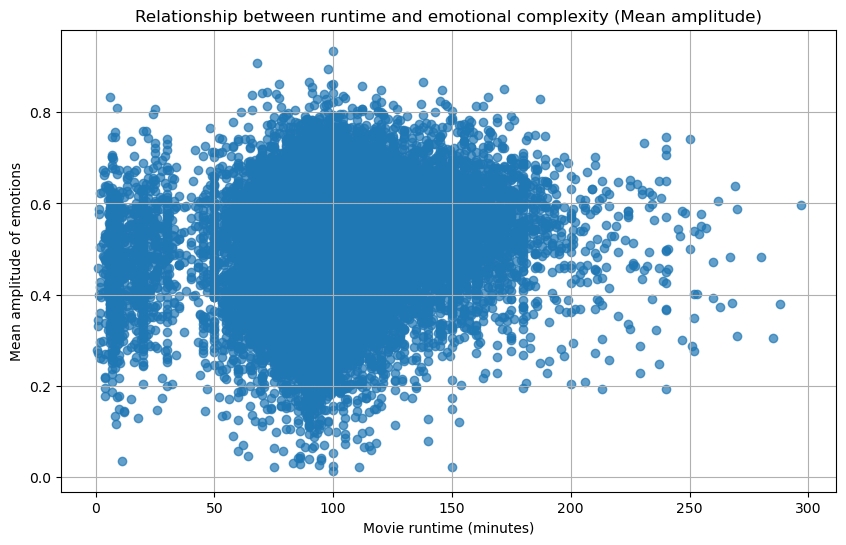

In [16]:
def plot_runtime_vs_emotion_amplitude(emotion_metrics):
    # Calculate mean amplitude of emotions
    emotion_metrics["mean_amplitude"] = emotion_metrics[[col for col in emotion_metrics.columns if "lambda_0" in col]].mean(axis=1)

    # Plot the relationship between movie runtime and mean amplitude of emotions
    plt.figure(figsize=(10, 6))
    plt.scatter(emotion_metrics["Movie_runtime"], emotion_metrics["mean_amplitude"], alpha=0.7)
    plt.title("Relationship between runtime and emotional complexity (Mean amplitude)")
    plt.xlabel("Movie runtime (minutes)")
    plt.ylabel("Mean amplitude of emotions")
    plt.grid()
    plt.show()

# Usage
plot_runtime_vs_emotion_amplitude(emotion_metrics)


C:\Users\flori\AppData\Local\Temp\ipykernel_4244\2135952437.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


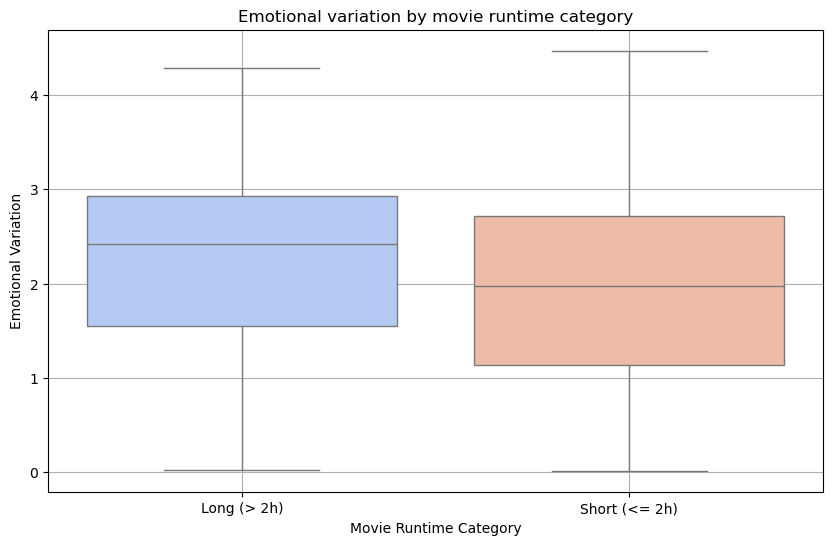

T-statistic: 22.27, P-value: 6.645e-106


In [13]:
def plot_emotion_variation_by_runtime(metrics_per_film):
    # Boxplot of emotional variations by runtime category
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="runtime_category",
        y="emotion_variation",
        data=metrics_per_film,
        palette="coolwarm"
    )
    plt.title("Emotional variation by movie runtime category")
    plt.xlabel("Movie Runtime Category")
    plt.ylabel("Emotional Variation")
    plt.grid()
    plt.show()

    # T test between long and short movies
    long_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Long (> 2h)"]["emotion_variation"]
    short_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Short (<= 2h)"]["emotion_variation"]

    t_stat, p_value = ttest_ind(long_movies, short_movies, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3e}")

# Usage
plot_emotion_variation_by_runtime(metrics_per_film)


In [14]:
def plot_emotional_variation_by_film_length(metrics_per_film):
    # Create a boxplot with Plotly for emotion variation by runtime category
    fig = px.box(metrics_per_film, 
                 x="runtime_category", 
                 y="emotion_variation", 
                 color="runtime_category", 
                 title="Emotional variation by film Length", 
                 labels={"runtime_category": "Film length category", 
                         "emotion_variation": "Mean Emotional Variation"},
                 color_discrete_sequence=["#636EFA", "#EF553B"])

    fig.update_layout(
        title="Emotional variation by film length",
        xaxis_title="Film length category",
        yaxis_title="Emotional variation",
        showlegend=False
    )

    # Save the figure as an HTML file
    pio.write_html(fig, file='emotional_variation_by_film_length.html', auto_open=True)

    # Test T between long and short movies
    long_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Long (> 2h)"]["emotion_variation"]
    short_movies = metrics_per_film[metrics_per_film["runtime_category"] == "Short (<= 2h)"]["emotion_variation"]

    t_stat, p_value = ttest_ind(long_movies, short_movies, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3e}")

    return fig, t_stat, p_value

# Usage
fig, t_stat, p_value = plot_emotional_variation_by_film_length(metrics_per_film)


T-statistic: 22.27, P-value: 6.645e-106


In [15]:
# Calculate the correlations for each emotion
emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
correlations = []

for emotion in emotions:
    emotion_variation = f"{emotion}_variation"
    metrics_per_film_cleaned[f"{emotion}_variation"] = (
        df_combined.groupby("Wikipedia_movie_ID")[emotion]
        .apply(lambda x: x.diff().abs().sum())
    )
    cleaned_data = metrics_per_film_cleaned.dropna(subset=["Movie_runtime", emotion_variation])
    correlation, p_value = pearsonr(cleaned_data["Movie_runtime"], cleaned_data[emotion_variation])
    correlations.append({"Emotion": emotion, "Correlation": correlation, "P-value": p_value})

# Results display
correlation_df = pd.DataFrame(correlations)
print(correlation_df)

# Visualization with Plotly
fig = px.bar(correlation_df, x="Emotion", y="Correlation", title="Correlation between movie runtime and emotional variation",
             labels={"Correlation": "Correlation coefficient"}, color="Correlation", color_continuous_scale="viridis")

fig.add_hline(y=0, line_dash="dash", line_color="red")

# Save the figure as an HTML file
pio.write_html(fig, file='correlation_emotional_variation.html', auto_open=True)


    Emotion  Correlation   P-value
0     anger    -0.028447  0.786638
1   disgust     0.054005  0.607154
2      fear    -0.071366  0.496637
3       joy     0.241630  0.019629
4   neutral     0.100126  0.339617
5   sadness    -0.057186  0.586117
6  surprise     0.200532  0.053938


### Analysis of Correlation between Movie Duration and Emotional Variation

The highest correlations are observed with joy and surprise, both showing positive correlations. This indicates that as the movie duration increases, there is a greater variation in these emotions. 

On the other hand, negative correlations suggest that the longer the movie, the less variation there is in other emotions. This could imply that longer movies tend to stabilize certain emotional arcs, reducing the fluctuation in emotions such as anger, disgust, fear, neutral, and sadness.